<a href="https://colab.research.google.com/github/HannahMwende/Driver-Drowniness-dectection-system/blob/main/driver_drowniness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver drowniness detection system
#### Authors
* Ann Maureen
* Hannah Mutua
* Ibrahim Hafiz
* Samuel Kabati
* Angela Cheruto
* Janet Gachoki



## Business understanding

### Introduction
The number of people killed and injured in road crashes in Kenya went up by 17.5% in September 2021 as compared to the same period in 2020, according to National Transport and Safety Authority. Falling asleep on the wheel is one of the major causes of these accidents. Research has indicated that going more than 20 hours without sleep is the equivalent of having a blood-alcohol concentration of 0.08%.

### Problem statement
A car brand company is looking to introduce a safety feature due to the rising number of accidents resulting from drowsy drivers.

We would want to propose developing a neural network that can determine if eyes are open or closed and, when used in conjunction with computer vision, can determine whether a living human has had their eyes closed for longer than three seconds because of this serious problem.

### Main objective
To develop a neural network that can detect if eyes are open or closed.


### Specific Objectives
* Determine the region of interest which is the eye region
* Deploy our model to a webcam application that will classify a driver as having slept on the wheel if the positive class(eyes closed) is true for more than three frames.

### Metric of success
Our model will be considered successful if an AUC score of 0.97 will be attained .

### Understanding the problem context
For drowsiness detection, our goal is to correctly detect whether one has their eyes open or closed. If the eyes remain closed for more than three seconds the driver should receive an alert to wake them up.According to the following [article](<https://www.webmd.com/sleep-disorders/what-to-know-microsleep>) by WebMD if you doze off for 3 seconds while at a speed of 27 metres per second you can travel 92 metres in the wrong direction. 
Using the Area Under the curve (AUC) as our metric we are looking at the probability that our model will rank a true positive higher than a false positive.
With an AUC score of 0.97, our model is able to correctly separate the open eyes and the closed eyes 97 times out of 100.  

### Defining Experimental design
* Import the relevant libraries used in the analysis.

* Load and preview images

* Explore the dataset we will use for our project.

* Exploratory Data Analysis (EDA)

* Data Pre-processing

* Modelling and Evaluation

* Challenging the model

* Conclusion

* Recommendations

## Data understanding
The data is from [Kaggle](<https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset>) it was created with the help of a larger-scale dataset of human eyes from Media Research Lab.

The dataset contains images of the eye state whether open or closed. Of the 4000 images, 2000 are open eyes, and 2000 are closed eyes some with glasses some without. The images have a bit depth of 8. The dataset contains images with high and low resolution since they were captured by different devices under different lighting conditions.

### Loading dataset

In [22]:
#Importing libraries
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image as im
import seaborn as sns

In [5]:
#Connecting colab to gooogle drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading data using os.listdir 

In [7]:
 #Printing contents of train folder
print(os.listdir("/content/drive/Shareddrives/Elite Drive/train"))

['Open_Eyes', 'Closed_Eyes']


In [8]:
#Loading images and converting to array
def load_images_from_folder(folder,eyes):
    images=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename))
        img=cv2.resize(img,(80,80))
        images.append([img,eyes])
    return images


In [9]:
#Loading images from folders

folder="/content/drive/Shareddrives/Elite Drive/train/Open_Eyes"
open_eyes=load_images_from_folder(folder,0)

folder="/content/drive/Shareddrives/Elite Drive/train/Closed_Eyes"
closed_eyes=load_images_from_folder(folder,1)

##Previewing data

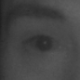

In [10]:
#Displaying an image from open eyes
data=im.fromarray(open_eyes[0][0])
data

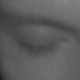

In [11]:
#Dispaying an image from closed eyes
data=im.fromarray(closed_eyes[119][0])
data

##Data Exploration
For better understanding of our data we will plot our visuals

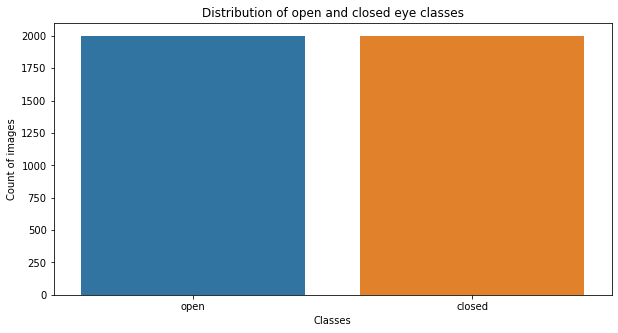

In [12]:
#Visualization of open and closed eyes
open=len(open_eyes)
closed=len(closed_eyes)
data={
    'open':open,
    'closed':closed,
}
classes=list(data.keys())
values=list(data.values())
plt.figure(figsize=(10,5))
sns.barplot(x=classes,y=values)
plt.xlabel("Classes")
plt.ylabel("Count of images")
plt.title('Distribution of open and closed eye classes')
plt.show()

In [13]:
print("The total number of images of the Opened eyes:", len(open_eyes))
print("The total number of images of the Closed eyes:", len(closed_eyes))


The total number of images of the Opened eyes: 2000
The total number of images of the Closed eyes: 2000


##Data Pre-processing

In [14]:
#Combining the dataset
eyes=open_eyes+closed_eyes


In [15]:
#Setting up images with X being images and y being labels
X=[]
y=[]

for features, label in eyes:
    X.append(features)
    y.append(label)

In [16]:
#Converting image to array for modelling and scaling by dividing by 255
X=np.array(X).reshape(-1,80,80,3)
y=np.array(y)
X=X/255.0

In [17]:
# Splitting the data 

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=23 )

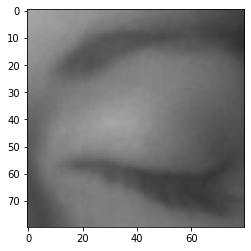

In [18]:
plt.figure()
plt.imshow(X_train[10])
plt.show()

In [19]:
#class names for images shown below 

class_names=['open','close']

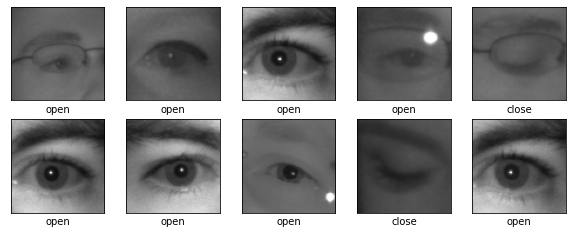

In [20]:
#producing images of training set with corresponding label
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

In [21]:
#creating a function that returns a Keras model

def deep_learning_model(dense_neurons1=128,dense_neurons2=128,dense_neurons3=128,layout='',filters=32,dropout=None,pooling=None):
  model=Sequential()
  if layout== '5x5':
    model.add(Conv2D(filters=filters, kernel_size=(5,5),activation='relu',input_shape=(80,80,3)))

  if layout=='3x3'or layout== '2*3x3':
    model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))

#adding pooling for convlutional layers
  if pooling!=None:
    model.add(MaxPooling2D(pool_size=(2,2)))

  if layout=='2*3x3':
    #second layer
      model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))
#adding pooling on 2*3x3
  if pooling !=None and layout =='2*3x3':
    model.add(MaxPooling2D(pool_size=(2,2)))

#flatten model for dense layers
  model.add(Flatten())
  model.add(Dense(dense_neurons1,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons2,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons3,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))

#adding output layer

  model.add(Dense(1,activation='sigmoid'))

  #compiling using binary cross entropy and using AUC as metric 
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.AUC(curve='PR')])

  return model
